In [3]:
import lasagne
import theano
import theano.tensor as T
import numpy as np
from scipy.io import loadmat
import matplotlib.pylab as plt
%matplotlib inline

Make sure we generate the same data every time by fixing the seed

In [4]:
np.random.seed(42)

Data is n sums of sinusoids of random frequency, samples at 100 times in the interval [-100,100]. The complexity of the sequences are controlled by m, the number of term-sinusoids.

In [5]:
x = np.linspace(-100,100,100)
n,m = (23,6)
constants = 10*np.pi*np.random.rand(n,m)
x = np.array([sum([np.sin(b*x) for b in a]) for a in constants])

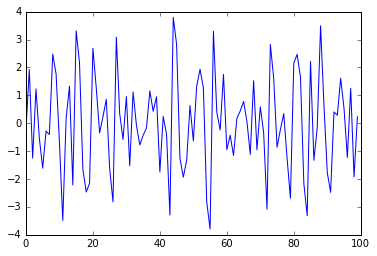

In [7]:
plt.plot(x[5].T);

Lasagne's GRUlayer expects a three-dimensional input (batch_size,seq_len,dimension_of_signal)

In [8]:
X = x[:,None]

In [9]:
X.shape

(23, 1, 100)

In [10]:
X = X.transpose((0,2,1))

The output is supposed to be the next frame

In [11]:
x = X[:,:-1]
y = X[:,1:]

In [12]:
x.shape,y.shape

((23, 99, 1), (23, 99, 1))

Lasagne also requires float32's for some reason (probably to save space)

In [13]:
x = x.astype(np.float32)
y = y.astype(np.float32)

Since Lasagne won't work with singular hidden units, the model has two, but we only use one in the cost function.

In [14]:
NUM_INPUTS = 1
NUM_UNITS_ENC = 30

In [15]:
#symbolic theano variables. Note that we are using imatrix for X since it goes into the embedding layer
x_sym = T.matrix()

In [16]:
x_sym = T.ftensor3()
y_sym = T.ftensor3()

First we try with a batch size of one, to test the code with long waiting times

In [17]:
x_first = x[0:1,:].astype(np.float32)
y_first = y[0:1,:].astype(np.float32)

In [18]:
x_first.shape,y_first.shape

((1, 99, 1), (1, 99, 1))

In [19]:
l_in = lasagne.layers.InputLayer((None,None,1), input_var = x_sym)
batch_size,seq_len,_ = l_in.input_var.shape
l_enc = lasagne.layers.GRULayer(l_in, num_units=NUM_UNITS_ENC, name='GRUEncoder')
l_reshape = lasagne.layers.reshape(l_enc, (-1,NUM_UNITS_ENC))
l_dense = lasagne.layers.DenseLayer(l_reshape,1,nonlinearity=lasagne.nonlinearities.linear)
l_out = lasagne.layers.reshape(l_dense, (batch_size,seq_len,1))
# make sure output layer's range matches the range of input, fx with linear output layer
print(lasagne.layers.get_output(l_in, inputs={l_in: x_sym}).eval({x_sym: x_first}).shape)
print(lasagne.layers.get_output(l_enc, inputs={l_in: x_sym}).eval({x_sym: x_first}).shape)
print(lasagne.layers.get_output(l_reshape, inputs={l_in: x_sym}).eval({x_sym: x_first}).shape)
print(lasagne.layers.get_output(l_dense, inputs={l_in: x_sym}).eval({x_sym: x_first}).shape)
print(lasagne.layers.get_output(l_out, inputs={l_in: x_sym}).eval({x_sym: x_first}).shape)

(1, 99, 1)
(1, 99, 30)
(99, 30)
(99, 1)
(1, 99, 1)


In [20]:
# cost function is mean absolute difference between predicted and actual next step.
predicted_values = lasagne.layers.get_output(l_out)
cost = T.mean(abs(predicted_values - y_sym))

In [21]:
cost.eval({x_sym: x_first,y_sym: y_first})

array(1.7134694046648673)

In [26]:
all_parameters = lasagne.layers.get_all_params([l_out], trainable=True)
#add grad clipping to avoid exploding gradients
all_grads = [T.clip(g,-3,3) for g in T.grad(cost, all_parameters)]
#updates = lasagne.updates.adam(all_grads, all_parameters, learning_rate=0.001)
updates = lasagne.updates.adam(all_grads, all_parameters, learning_rate=0.005)

In [27]:
print("Trainable Model Parameters")
print("-"*40)
for param in all_parameters:
    print(param, param.get_value().shape)
print("-"*40)

Trainable Model Parameters
----------------------------------------
GRUEncoder.W_in_to_updategate (1, 30)
GRUEncoder.W_hid_to_updategate (30, 30)
GRUEncoder.b_updategate (30,)
GRUEncoder.W_in_to_resetgate (1, 30)
GRUEncoder.W_hid_to_resetgate (30, 30)
GRUEncoder.b_resetgate (30,)
GRUEncoder.W_in_to_hidden_update (1, 30)
GRUEncoder.W_hid_to_hidden_update (30, 30)
GRUEncoder.b_hidden_update (30,)
W (30, 1)
b (1,)
----------------------------------------


In [28]:
# compile training function (in C or somesuch)
train_func = theano.function([x_sym, y_sym], [cost, predicted_values], updates=updates)

In [29]:
c = 0
csts = []
preds = []
num_epochs = 3000
while c < num_epochs:
    cst, pred = train_func(x,y)
    csts.append(cst)
    preds.append(pred)
    c += 1
    #print(c)

In [40]:
while c < num_epochs*2:
    cst, pred = train_func(x,y)
    csts.append(cst)
    preds.append(pred)
    c += 1
    #print(c)

3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196
3197
3198
3199
3200


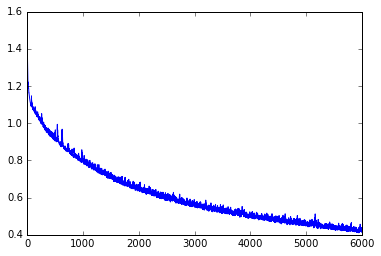

In [41]:
plt.plot(csts);

In [45]:
print(csts[-1])

0.42823533734698516


Compare prediction generated by a randomly initialized network

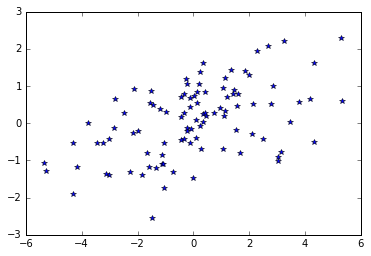

In [42]:
plt.plot(y_first[:,:,0].T.flatten(),preds[0][0,:,0].T.flatten(),'*')

to prediction by trained network (ideal is a straight line)

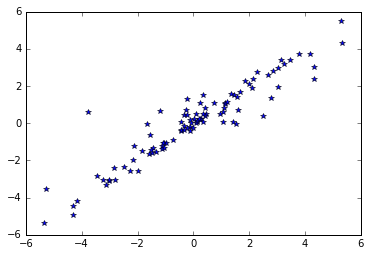

In [43]:
plt.plot(y_first[:,:,0].T.flatten(),preds[-1][0,:,0].T.flatten(),'*')

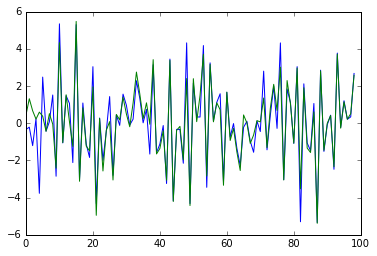

In [44]:
plt.plot(y_first[0,:,0].T)
plt.plot(preds[-1][0,:,0].T)